# Store Sale Dataset (Kaggle)
https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data
- Create EDA for store sales data
- Create prediciton model - SARIMA

In [2]:
import pandas as pd
import numpy as np
import math
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

from statsmodels.tsa.stattools import adfuller
import itertools
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Dataset Detail

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## Data Cleaning

In [6]:
df.isna().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [7]:
df[['Order Date', 'Ship Date']]

,Order Date,Ship Date
0,08/11/2017,11/11/2017
1,08/11/2017,11/11/2017
2,12/06/2017,16/06/2017
3,11/10/2016,18/10/2016
4,11/10/2016,18/10/2016
...,...,...
9795,21/05/2017,28/05/2017
9796,12/01/2016,17/01/2016
9797,12/01/2016,17/01/2016
9798,12/01/2016,17/01/2016


In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format = "%d/%m/%Y")
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = "%d/%m/%Y")

In [9]:
df['Order Date'].dt.year.unique()

array([2017, 2016, 2015, 2018], dtype=int32)

## EDA

#### 1. Check sales trend

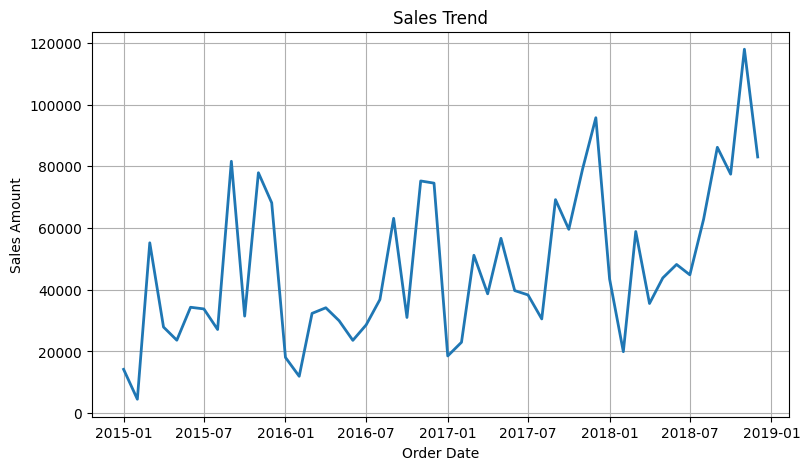

In [10]:
# Create Day, Month, Year columns from Order Date
df['Day'] = df['Order Date'].dt.day
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year

df['Order_MonYr'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format = "%Y-%m")
summary = df.groupby('Order_MonYr')['Sales'].sum().reset_index()

plt.figure(figsize = (9, 5))
plt.plot(summary['Order_MonYr'], summary['Sales'], linestyle = ('solid'), linewidth = 2)
plt.xlabel('Order Date')
plt.ylabel('Sales Amount')
plt.title('Sales Trend')
plt.grid(True)
plt.show()

#### 2. Sales by States

In [11]:
State_sales = df.groupby('State')['Sales'].sum().reset_index().sort_values(by = "Sales", ascending = False)
State_sales.head()

,State,Sales
3,California,446306.4635
30,New York,306361.1470
41,Texas,168572.5322
45,Washington,135206.8500
36,Pennsylvania,116276.6500


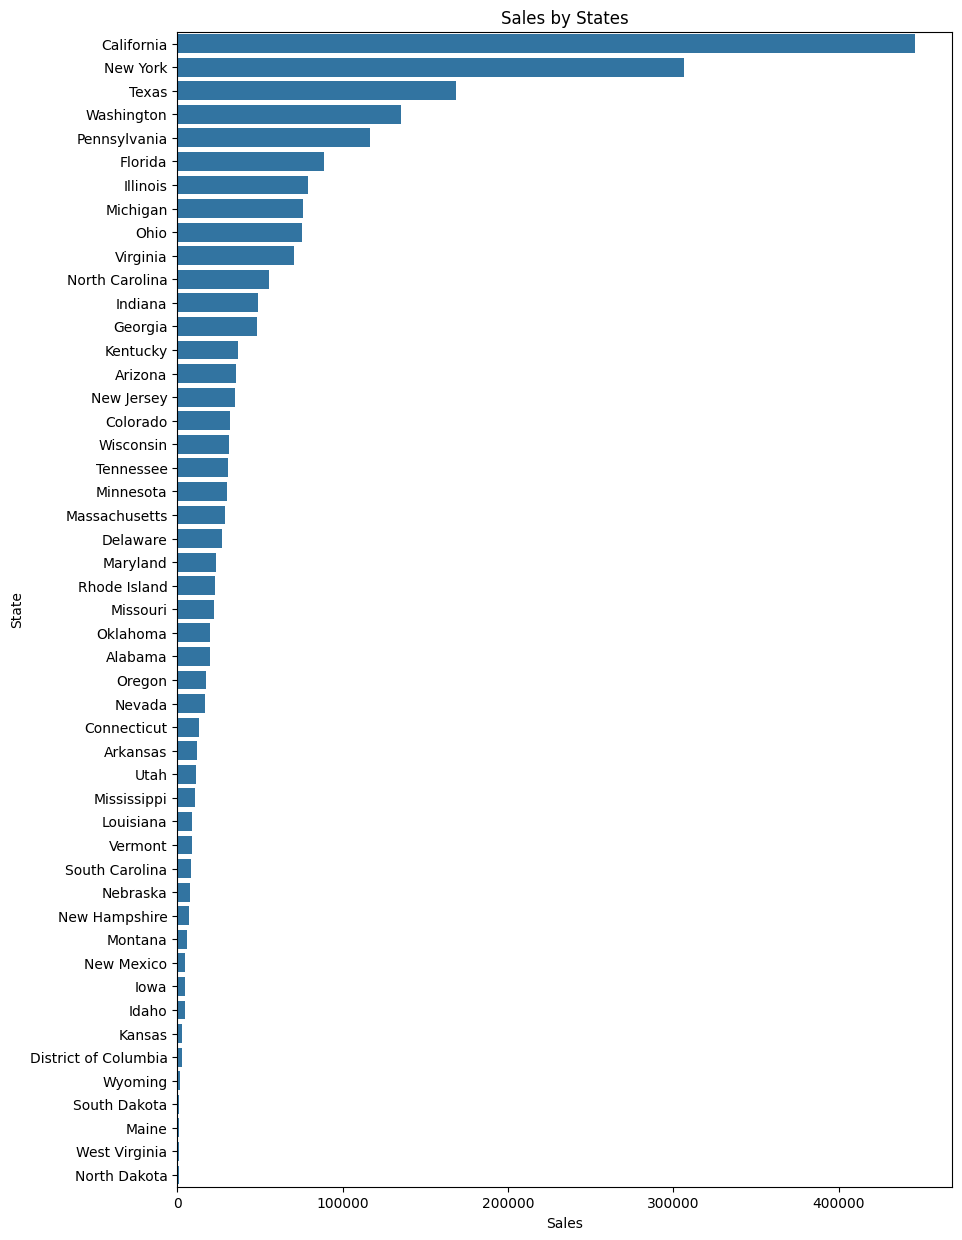

In [12]:
plt.figure(figsize = (10, 15))
ax = sns.barplot(x = 'Sales', y = 'State', data = State_sales)

plt.xlabel('Sales')
plt.ylabel('State')
plt.title('Sales by States')
plt.show()

#### 3. Categorical Data Distribution
- Segment
- Region
- Category
- Sub-Category

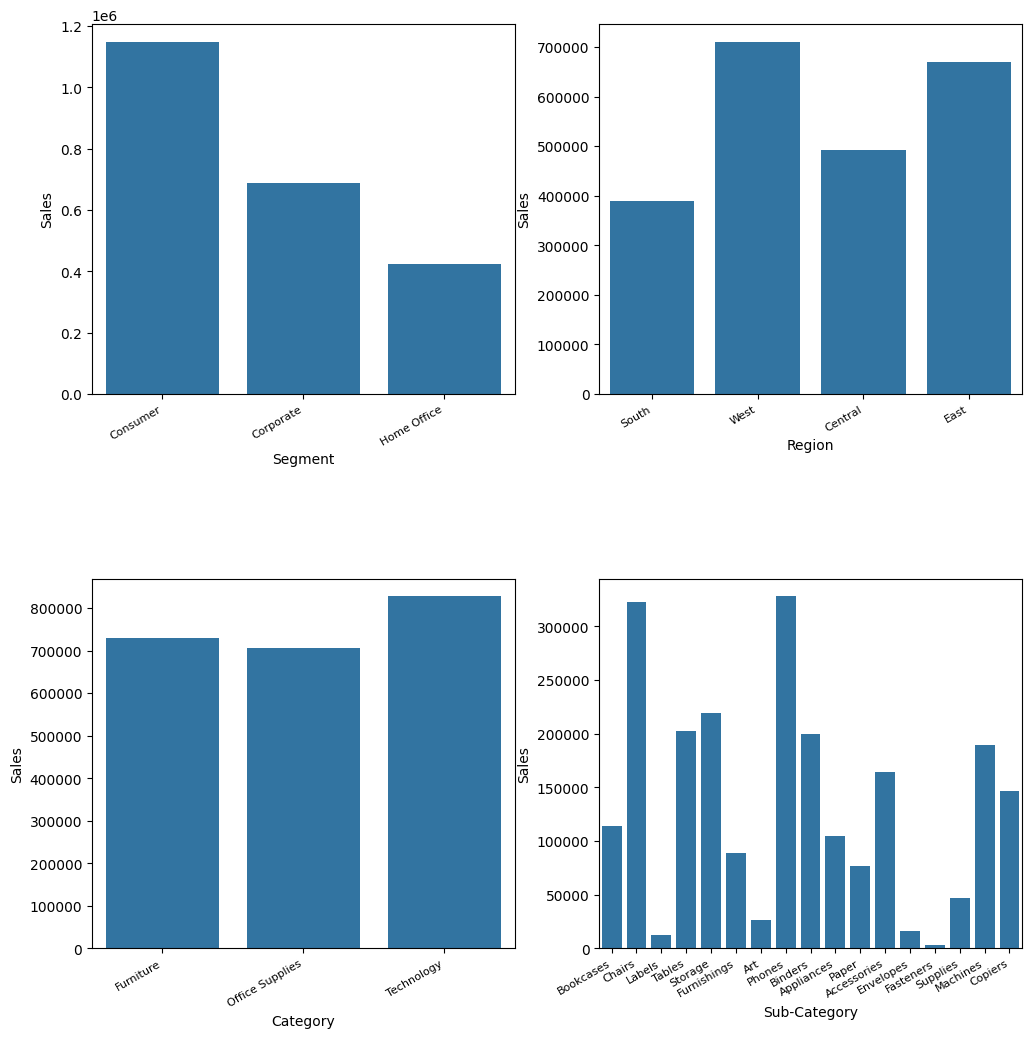

In [13]:
columns = ['Segment', 'Region', 'Category', 'Sub-Category']

fig, axes = plt.subplots(2, 2, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.5)

for i, column in enumerate(columns):
    ax = axes[i//2, i%2]
    sns.barplot(x = column, y = "Sales", data = df, estimator = np.sum, errorbar = None, ax = ax)
    ax.set_ylabel('Sales')
    ax.set_xlabel(column)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'right', fontsize = 8)

plt.show()

In [ ]:
cat_summary = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()

fig = px.sunburst(cat_summary, path=['Category', 'Sub-Category'], values='Sales')
fig.show()

## Time Series Analysis & Forcast

In [14]:
# Create dataset
df_sort = df.sort_values('Order Date', ascending = True).set_index('Order Date')
df_sort_sales = pd.DataFrame(df_sort['Sales'])
df_sort_sales.head()

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536


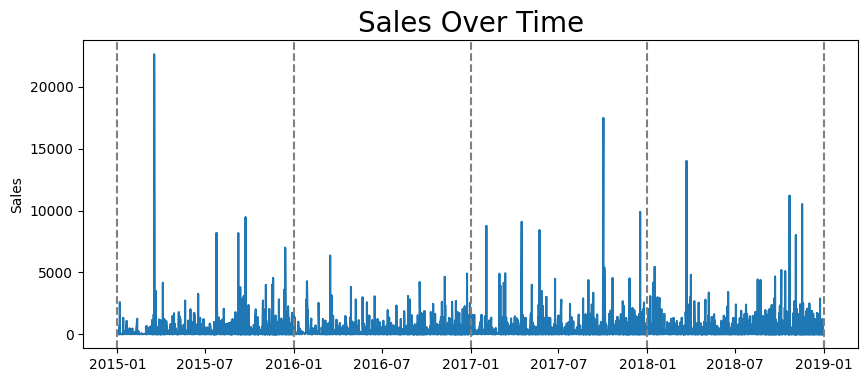

In [15]:
plt.figure(figsize = (10, 4))
plt.plot(df_sort_sales)
plt.title('Sales Over Time', fontsize = 20)
plt.ylabel('Sales')
for year in range(2015, 2020):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color = 'gray', linestyle = '--')

#### 1. Check if the the data is stationary with ADF Test
- Stationary
  * Stationary is desirable in time series analysis
  * A time series is considered stationary when statistical properties (mean, variance, and autocerrlation do not change over time)
  * ADF tests the null hypothesis that a unit root is present in a time series sample
- P-value
  * p-value is significantly low (<= 0.05 in this case), the null hypothesis can be rejected and consider the data stationary

In [16]:
result = adfuller(df_sort_sales)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('')
# The result[1] is p-value
if result[1] <= 0.05:
    print("!! Data is stationary !!")
else:
    print("xx Data is not stationary xx")

ADF Statistic: -99.08279579913308
p-value: 0.0

!! Data is stationary !!


#### 2. Check for autocorrelation and partial autocorrelation
- Used in time series to understand the temporal dependencies within the dataset
- Also help identify the order of autoregressive (AR) and moving average (MA) while fitting time series

The ACF plot helps you understand the correlation between an observation and lagged versions of itself. Each point on the ACF plot represents the correlation between the series at time "t" and the series at a previous time "t - k," where "k" is the lag. A sharp drop-off in the ACF plot suggests that the data doesn't have a long memory, while a slow decay may indicate a trend or seasonality.

In the context of ARIMA modeling, the ACF plot is used to determine the order of the MA component. Specifically, if the ACF plot exhibits a sharp drop after a certain lag ("q"), it suggests that an MA(q) term should be included in the model.

The PACF plot helps you understand the direct relationship between an observation and its past values while removing the correlation due to other lags. Each point on the PACF plot represents the partial correlation between the series at time "t" and the series at time "t - k" while controlling for the influence of the lags between "t" and "t - k."

In ARIMA modeling, the PACF plot is used to determine the order of the AR component. If the PACF plot exhibits a sharp drop after a certain lag ("p"), it suggests that an AR(p) term should be included in the model.


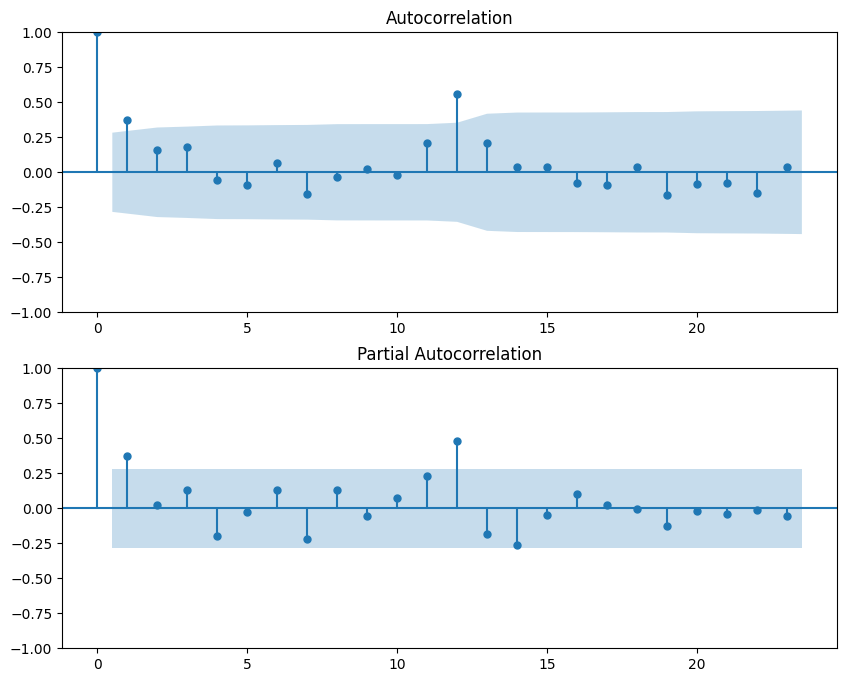

In [17]:
df_corr = df.copy()
df_corr['Order Date'] = pd.to_datetime(df_corr['Order Date'])
df_corr.set_index('Order Date', inplace=True)
df_monthly = df_corr['Sales'].resample('M').sum()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_monthly, lags=23, ax=ax1)
plot_pacf(df_monthly, lags=23, ax=ax2)

plt.show()

**Conclusion**<br>
- PACF
  * We should start our Auto Regressive model with lags of 1, 12<br>
- ACF
  * The significant point in ACF happended in Lag of 12, so we should use SARIMA with lag of 12 months.

#### 3. Modeling

##### 3.1 SARIMA

##### I. Grid Search SARIMA

- Convert the dataset into "Monthly" by adding up all the sales amount each month
- Split train-test data
  * We want to estimate the last year (2018) Sales

In [18]:
df_sort_sales.reset_index(inplace = True)
df_sort_sales = df_sort_sales.resample('M', on='Order Date').sum()

In [19]:
train_end = datetime.datetime(2018, 1, 1)
test_end = datetime.datetime(2018, 1, 2)

train_data = df_sort_sales[:train_end]
test_data = df_sort_sales[test_end:]

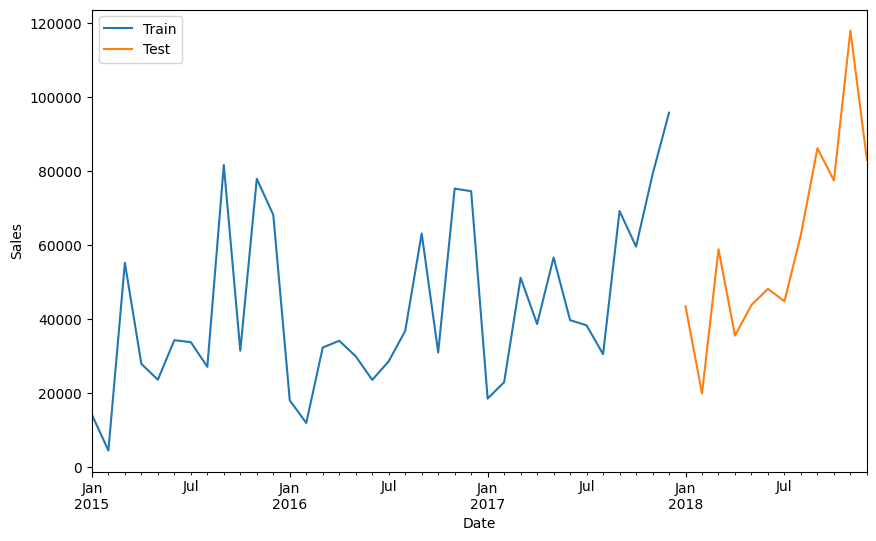

In [20]:
ax = train_data.plot(figsize = (10, 6))
test_data.plot(ax = ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- Grid Search SARIMA parameter

In [21]:
p_values = range(0, 3)
d_values = [0]
q_values = range(0, 3)
# ---- Seasonal parameters below ---
P_values = range(0, 2)
D_values = range(0, 1)
Q_values = range(0, 2)
m_values = [12]

# Create all combination of SARIMA parameters
param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, 
                                            D_values, Q_values, m_values))

# Initialize best AIC and best params set
best_aic = float("inf")
best_params = None

# Grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(train_data, 
                              order = order,
                              seasonal_order = seasonal_order)
        result = model.fit(disp = False)
        aic = result.aic
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
            if aic < best_aic:
                best_aic = aic
                best_params = params
        else:
            print(order, seasonal_order, 'not converged')
    except:
        continue

# Print the best parameters and AIC
print("Best Parameters: ", best_params)
print("Best AIC: ", best_aic)

(0, 0, 0) (0, 0, 0, 12) 880.891059558751
(0, 0, 0) (0, 0, 1, 12) 865.9210071884935
(0, 0, 0) (1, 0, 0, 12) 821.3903599596633
(0, 0, 0) (1, 0, 1, 12) 833.288661646999
(0, 0, 1) (0, 0, 0, 12) 868.1565722552019
(0, 0, 1) (0, 0, 1, 12) 865.9456431561441
(0, 0, 1) (1, 0, 0, 12) 863.7923910469826
(0, 0, 1) (1, 0, 1, 12) 865.6058364790398
(0, 0, 2) (0, 0, 0, 12) 868.6877989432198
(0, 0, 2) (0, 0, 1, 12) 867.9648317152873
(0, 0, 2) (1, 0, 0, 12) 866.7587887718497
(0, 0, 2) (1, 0, 1, 12) 868.6254112559328
(1, 0, 0) (0, 0, 0, 12) 839.5661310388479
(1, 0, 0) (0, 0, 1, 12) 833.1323460812414
(1, 0, 0) (1, 0, 0, 12) 828.5119428185425
(1, 0, 0) (1, 0, 1, 12) 830.3211302762907
(1, 0, 1) (0, 0, 0, 12) 832.7172304302483
(1, 0, 1) (0, 0, 1, 12) 825.8006739131891
(1, 0, 1) (1, 0, 0, 12) 821.123120548176
(1, 0, 1) (1, 0, 1, 12) 822.8422768027988
(1, 0, 2) (0, 0, 0, 12) 834.648342052982
(1, 0, 2) (0, 0, 1, 12) 829.758284364381
(1, 0, 2) (1, 0, 0, 12) 826.2242962392575
(1, 0, 2) (1, 0, 1, 12) 827.96725598481

- SARIMA MODEL
  * We have the best parameters from the grid search
  * Order (1, 0, 1)
  * Seasonal Order (1, 0, 0, 12)

In [22]:
model = sm.tsa.SARIMAX(train_data, 
                      order = best_params[:3],
                      seasonal_order = best_params[3:])
result = model.fit()
# disp = False
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03922D+01    |proj g|=  2.09662D+01

At iterate    5    f=  1.13411D+01    |proj g|=  6.30436D-02

At iterate   10    f=  1.12941D+01    |proj g|=  5.05695D-03

At iterate   15    f=  1.12934D+01    |proj g|=  2.46514D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   2.465D-05   1.129D+01
  F =   11.293376674280221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -406.562
Date:                             Fri, 23 Feb 2024   AIC                            821.123
Time:                                     16:05:24   BIC                            827.457
Sample:                                 01-31-2015   HQIC                           823.334
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9585      0.157      6.114      0.000       0.651       1.266
ma.L1         -0.6832      0.613     -1.115      0.265      -1.884       0.518
ar.S.L12       0.6588      0.243      2.713      0.007       0.183       1.135
sigma2      5.173e+08   2.42e-10   2.14e+18      0.000    5.17e+08    5.17e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.63   Prob(JB):                         0.53
Heteroskedasticity (H):               0.50   Skew:                             0.46
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+34. Standard errors may be unstable.
"""

- ma.L1 seem like not significant enough by the p-value
- Check the model diagnositics
  * The standardized residual dosn’t have any obvious patterns.
  * The histogram plus KDE estimate must look similar to a normal distribution.
  * The majority of the point lying on the straight line in Normal Q-Q graph.
  * All lags are within the confidence band in ACF or correlogram.

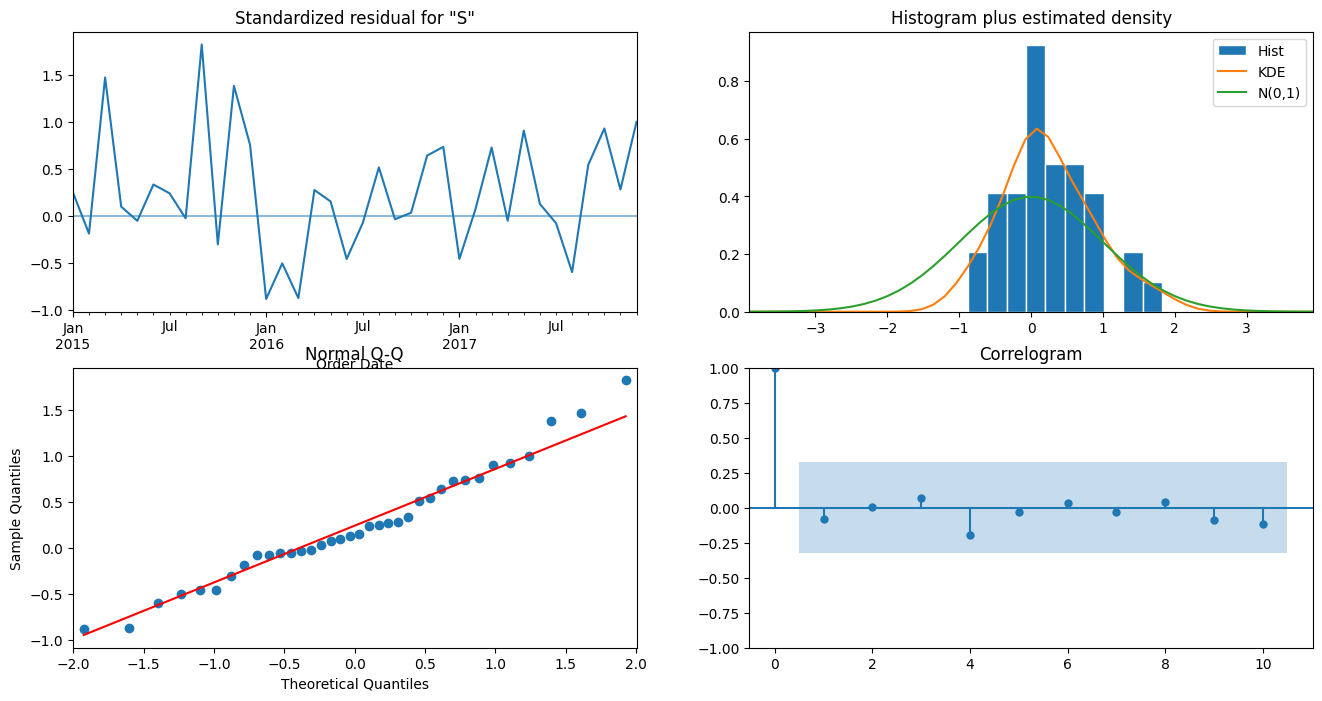

In [23]:
result.plot_diagnostics(figsize = (16, 8))
plt.show()

- Forecasting

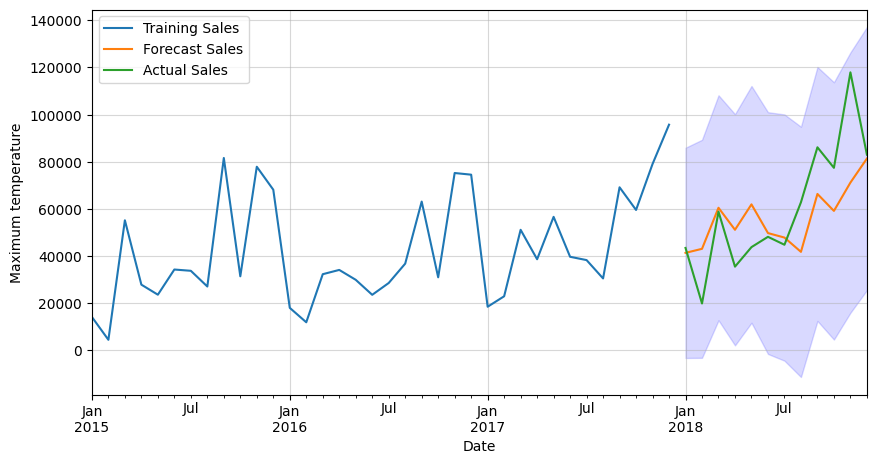

In [24]:
forecast = result.get_forecast(steps = 12)
forecast_values = forecast.predicted_mean
confidence_intervales = forecast.conf_int()

# Plot Results
ax = train_data[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
test_data.plot(ax=ax)
plt.fill_between(forecast_values.index, 
                 confidence_intervales['lower Sales'], 
                 confidence_intervales['upper Sales'], 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Sales', 
            'Forecast Sales', 
            'Actual Sales'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

- Evaluation

In [25]:
predicted_values = forecast_values.values
actual_values = test_data.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values - actual_values))
print("MAE: ", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100
print("MAPE: ", mape)

MAE:  14399.079215033826
RMSE:  19332.207927558553
MAPE:  28.420425152520394


**CONCLUSION**<br>
The evaluation shows that SARIMA dosn't perfrom well on this model.

##### II. AutoARIMA
Let's see if autoArima select better parameters

- AutoARIMA
  * Use auto_arima function to find the best parameters for ARIMA
  * Order = (1, 0, 0)
  * Seasonal Order = (0, 0, 1, 12) or (0, 0, 2, 12)
  * The parameter selection is different from the grid search

In [26]:
model = auto_arima(train_data, seasonal = True, m = 12, suppress_warnings = True)
model.fit(train_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                -404.869
Date:                                 Fri, 23 Feb 2024   AIC                            819.738
Time:                                         16:11:52   BIC                            827.656
Sample:                                     01-31-2015   HQIC                           822.501
                                          - 12-31-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.239e+04   1.35e+04      2.397      0.017    5905.476    5.89e+04
ar.L1          0.2557      0.295      0.865      0.387      -0.323       0.835
ma.S.L12       0.5520      0.519      1.063      0.288      -0.466       1.570
ma.S.L24       0.3423      0.665      0.515      0.607      -0.961       1.646
sigma2      4.745e+08      0.067   7.07e+09      0.000    4.75e+08    4.75e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.83   Prob(JB):                         0.41
Heteroskedasticity (H):               0.55   Skew:                             0.40
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.92e+26. Standard errors may be unstable.
"""

- Seem like ar.L1, ma.S.L12, and ma.S.L24 are not significant enough by the p-value
- Check the model diagnositics
  * The standardized residual dosn’t have any obvious patterns.
  * The histogram plus KDE estimate must look similar to a normal distribution.
  * The majority of the point lying on the straight line in Normal Q-Q graph.
  * All lags are within the confidence band in ACF or correlogram.

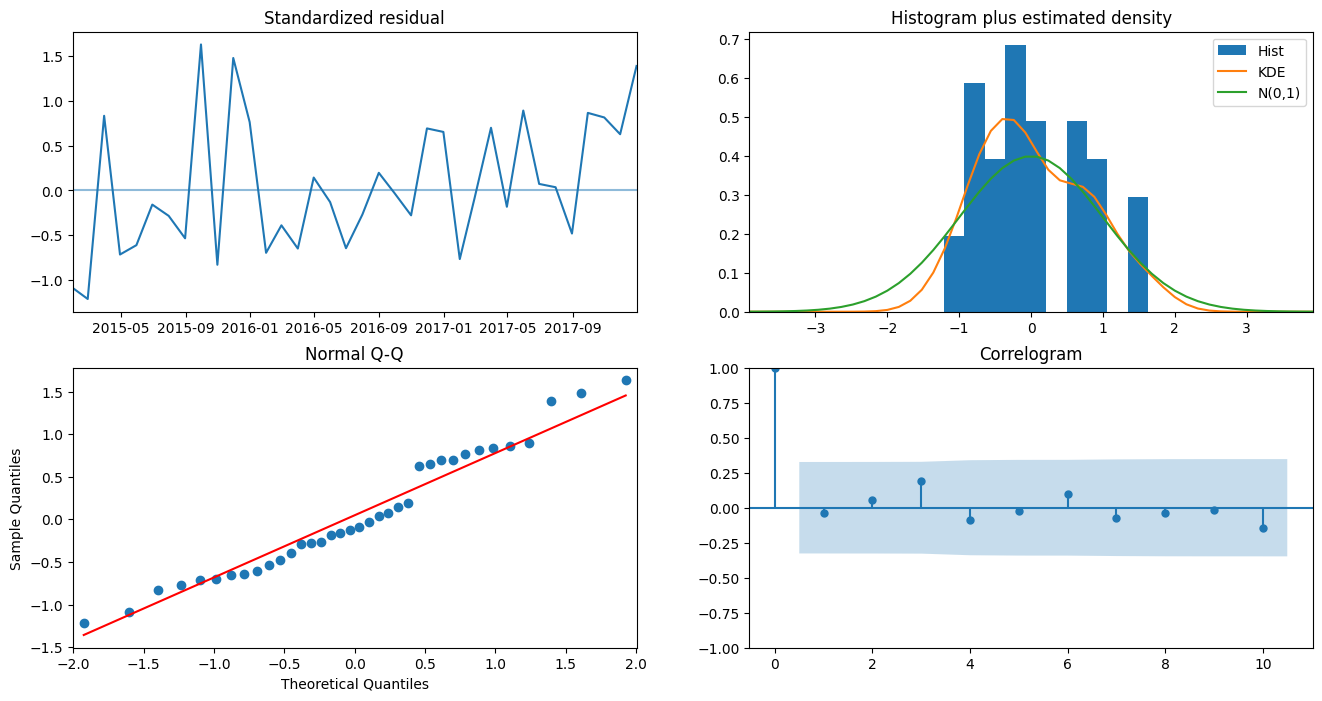

In [27]:
model.plot_diagnostics(figsize = (16, 8))
plt.show()

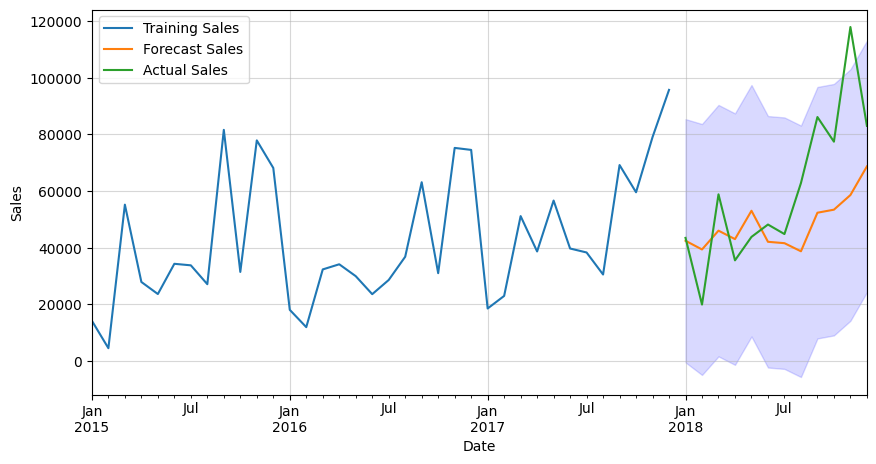

In [28]:
# Forcast for 1 year
forecast_auto, conf_int_auto = model.predict(n_periods=12,return_conf_int=True)

forecast_values_auto = forecast_auto
confidence_intervals_auto = conf_int_auto

# Plot results
ax = train_data.plot(figsize=(10,5))
forecast_auto.plot(ax=ax)
test_data.plot(ax=ax)
plt.fill_between(forecast_values_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Training Sales', 
            'Forecast Sales', 
            'Actual Sales'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(alpha=0.5)
plt.show()

- Evaluation

In [29]:
predicted_values_auto = forecast_auto.values
actual_values = test_data.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values_auto - actual_values))
print("MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values_auto - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values_auto - actual_values) / actual_values)) * 100
print("MAPE:", mape)

MAE: 17909.757124281296
RMSE: 23731.9710266958
MAPE: 29.997587541577523


**CONCLUSION**<br>
Same as GridSearch, the evaluation shows that SARIMA dosn't perfrom well on this model.